# Cohort Revenue Retention Analysis: A Bayesian Approach

In this notebook we extend the cohort retention model presented in the post [Cohort Retention Analysis with BART](https://juanitorduz.github.io/retention_bart/) so that we just model retention **and**  per cohort simultaneously (we recommend reading the referenced post before this one).  The idea is to keep modeling the retention using a Bayesian Additive Regression Tree (BART) model (see [`pymc-bart`](https://www.pymc.io/projects/bart/en/latest/)) and linearly model the revenue per cohort using a Gamma distribution. We couple the retention and revenue components in a similar way as presented in the notebook [Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_ab_testing_introduction.html). For this simulated example we use a synthetic data set, see the blog post [A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/) For more details. [Here](https://github.com/juanitorduz/website_projects/blob/master/data/retention_data.csv) you can find the data to reproduce the results.

## Prepare Notebook

In [36]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from flax import linen as nn
from jax import random
from numpyro.contrib.module import flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    OneHotEncoder,
    StandardScaler,
)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We start by reading the data from previous posts (see [here](https://github.com/juanitorduz/website_projects/blob/master/Python/retantion_data.py) for the code to generate the data).

In [5]:
data_df = pd.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/retention_data.csv",
    parse_dates=["cohort", "period"],
)

data_df.head()

,cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users,revenue,retention
0,2020-01-01,150,2020-01-01,1430,0,-1.807373,0.140956,150,14019.256906,1.000000
1,2020-01-01,150,2020-02-01,1430,31,-1.474736,0.186224,25,1886.501237,0.166667
2,2020-01-01,150,2020-03-01,1430,60,-2.281286,0.092685,13,1098.136314,0.086667
3,2020-01-01,150,2020-04-01,1430,91,-3.206610,0.038918,6,477.852458,0.040000
4,2020-01-01,150,2020-05-01,1430,121,-3.112983,0.042575,2,214.667937,0.013333


## Data Preprocessing

In order to understand the user vs revenue relation, let's compute the revenue per users and per *active* users. The former represent the overall cohort contribution and the latter the contribution of the active users.

In [7]:
data_df["revenue_per_users"] = data_df["revenue"] / data_df["n_users"]
data_df["revenue_per_active_users"] = data_df["revenue"] / data_df["n_active_users"]

Observe that we have certain `periods` where we do not have active users. This induces `NaN` values in the `revenue_per_active_users`.

In [8]:
data_df.query("revenue_per_active_users.isna()")

,cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users,revenue,retention,revenue_per_users,revenue_per_active_users
53,2020-02-01,62,2020-07-01,1399,151,-3.542850,0.028117,0,0.0,0.0,0.0,NaN
55,2020-02-01,62,2020-09-01,1399,213,-3.111235,0.042646,0,0.0,0.0,0.0,NaN
78,2020-02-01,62,2022-08-01,1399,912,-4.465784,0.011365,0,0.0,0.0,0.0,NaN
87,2020-02-01,62,2023-05-01,1399,1185,-3.877776,0.020277,0,0.0,0.0,0.0,NaN
90,2020-02-01,62,2023-08-01,1399,1277,-4.726498,0.008780,0,0.0,0.0,0.0,NaN


We fill these missing values with zero.

In [9]:
data_df.fillna(value={"revenue_per_active_users": 0.0}, inplace=True)

We make a data train-test split.

In [10]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query("period <= @period_train_test_split")
test_data_df = data_df.query("period > @period_train_test_split")
test_data_df = test_data_df[
    test_data_df["cohort"].isin(train_data_df["cohort"].unique())
]

## EDA

For a detailed EDA of the data, please refer to the previous posts ([A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/) and [Cohort Retention Analysis with BART](https://juanitorduz.github.io/retention_bart/)). Here we want to focus in the retention and revenue relation.  First, let's recall how the retention matrix looks like.

Text(0.5, 1.0, 'Retention by Cohort and Period')

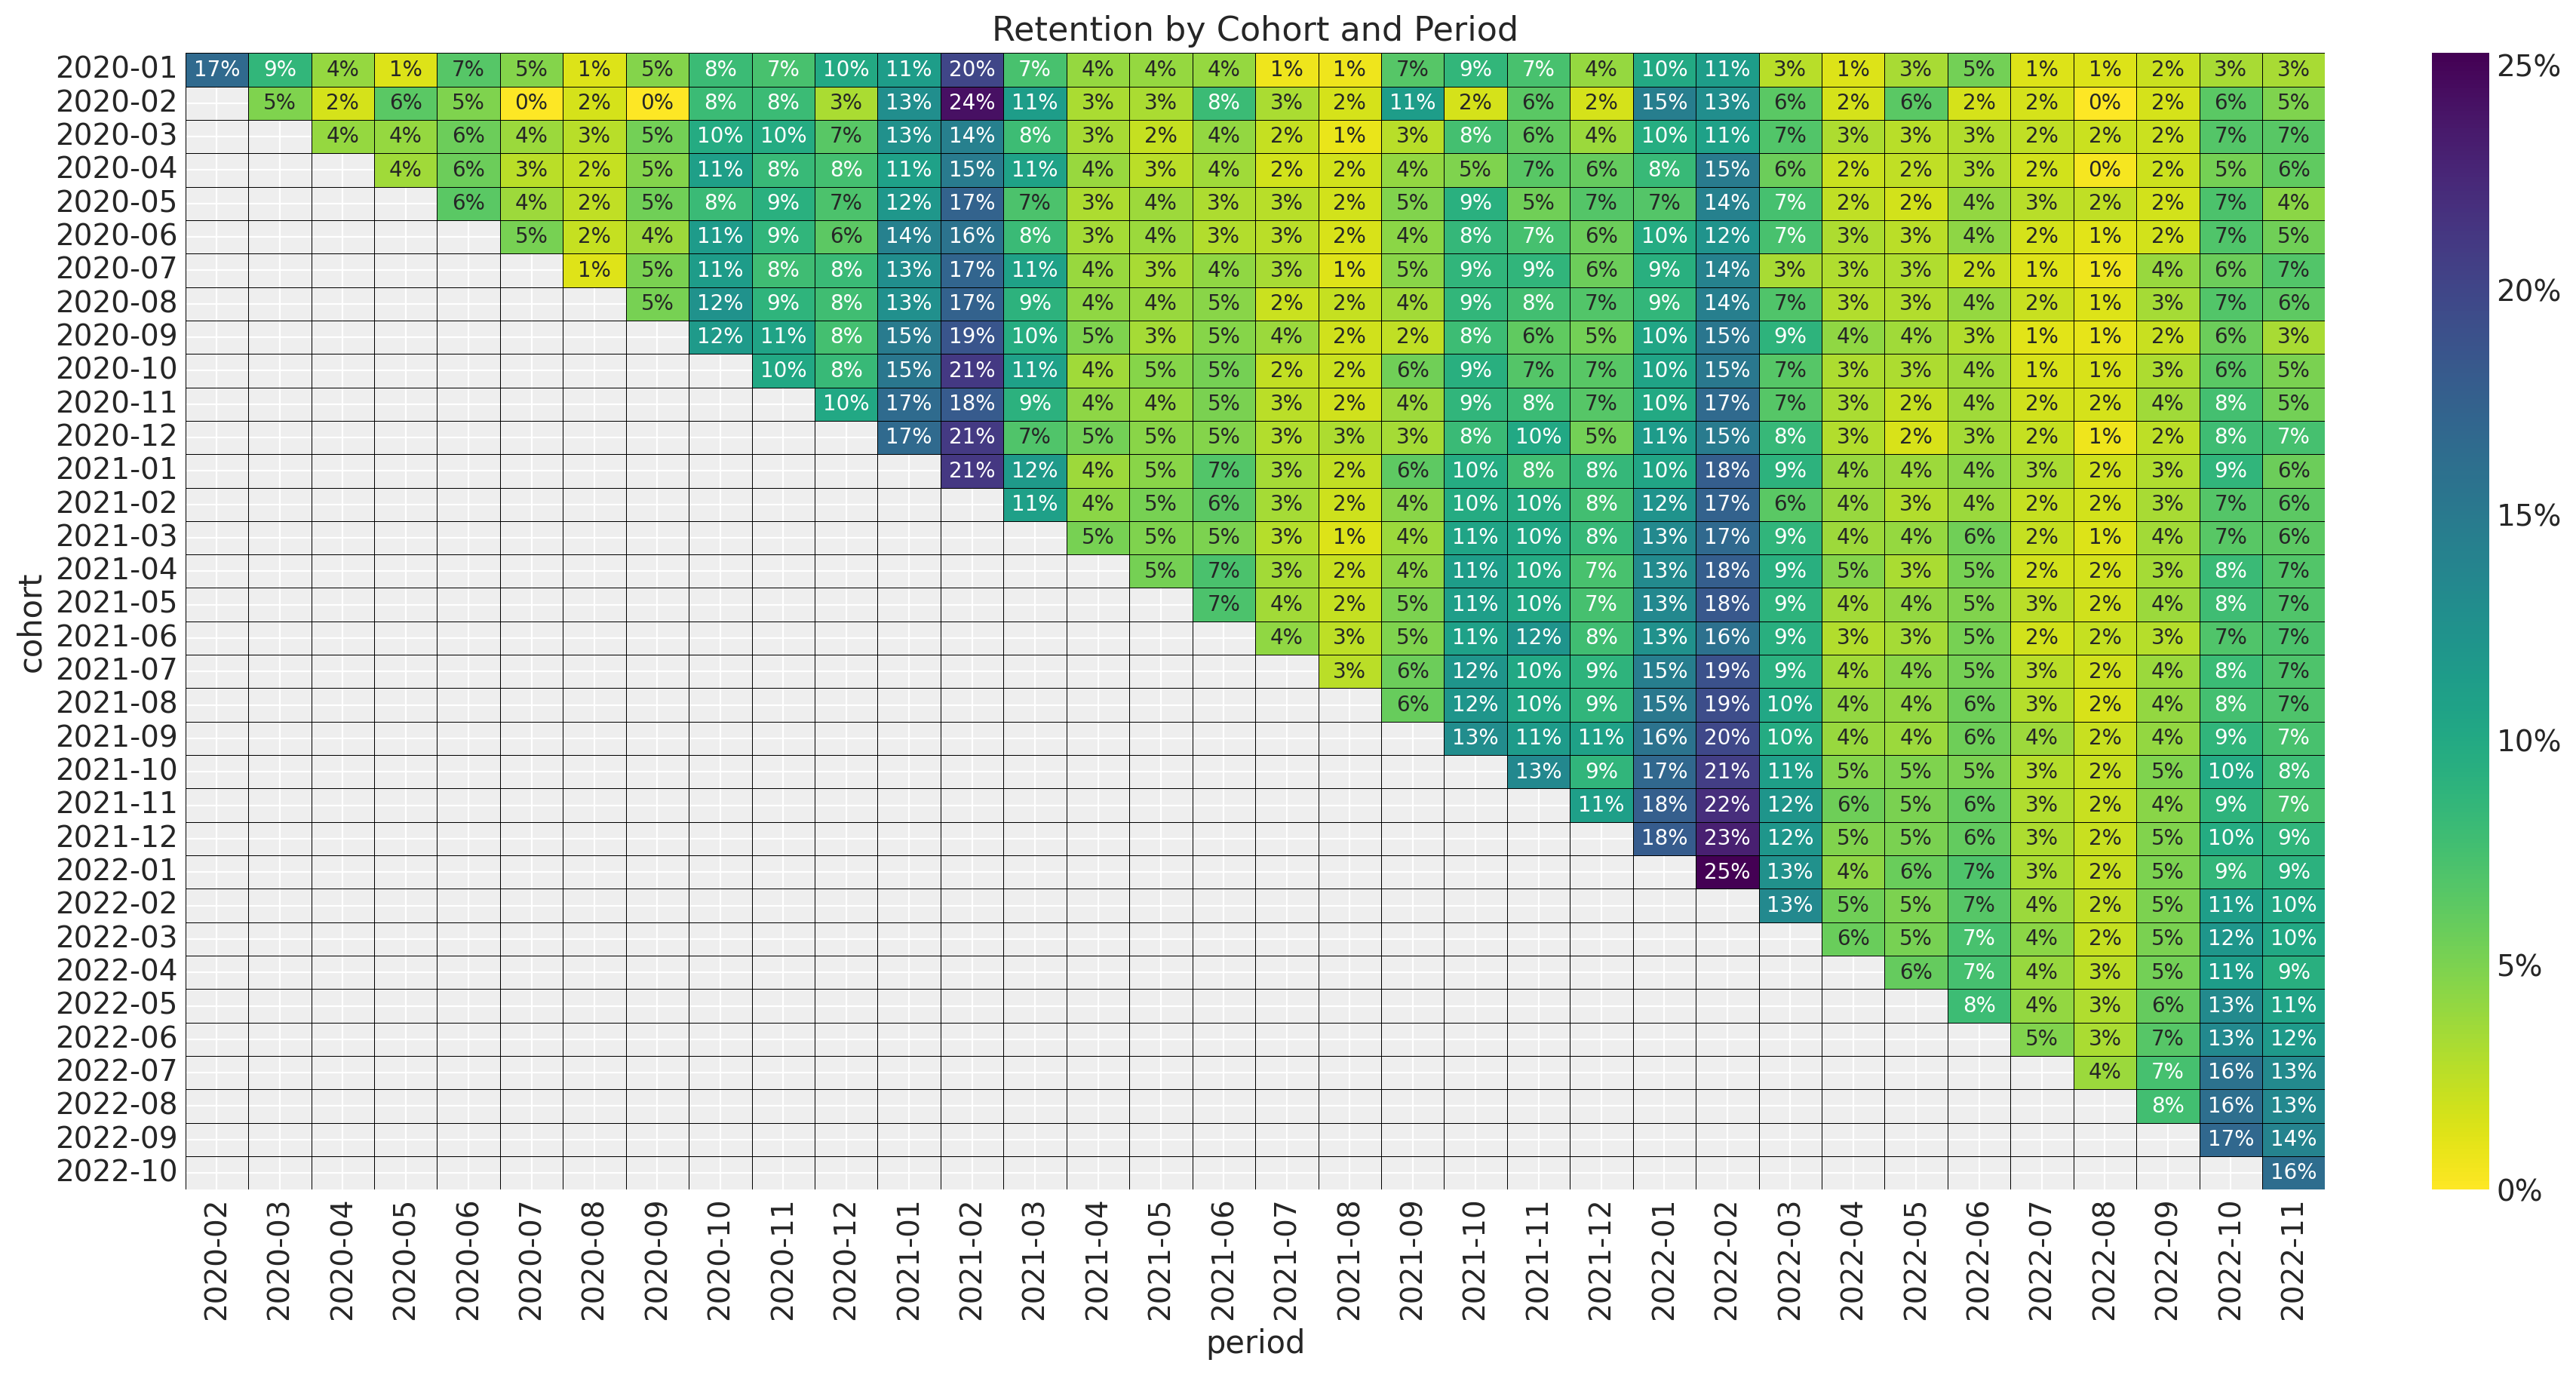

In [13]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot_table(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y :0.0%}")},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period")

## Model

Motivated by the analysis above we suggest the following retention-revenue model.

\begin{align*}
\text{Revenue} & \sim \text{Gamma}(N_{\text{active}}, \lambda) \\
\log(\lambda) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} ) \\
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{BART}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

### Data Transformations

We do similar transformations as in the previous posts.

In [15]:
eps = np.finfo(float).eps
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()
train_retention_logit = logit(train_retention + eps)
train_data_red_df["month"] = train_data_red_df["period"].dt.strftime("%m").astype(int)
train_data_red_df["cohort_month"] = (
    train_data_red_df["cohort"].dt.strftime("%m").astype(int)
)
train_data_red_df["period_month"] = (
    train_data_red_df["period"].dt.strftime("%m").astype(int)
)
train_revenue = train_data_red_df["revenue"].to_numpy() + eps
train_revenue_per_user = train_revenue / (train_n_active_users + eps)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = ["age", "cohort_age", "month"]
x_train = train_data_red_df[features]

train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

In [34]:

numerical_features = ["age", "cohort_age"]
categorical_features = ["month"]

numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_features_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_features_transformer, categorical_features),
    ]
).set_output(transform="pandas")

preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)

In [35]:
x_train_preprocessed

,num__age,num__cohort_age,cat__month_1,cat__month_2,cat__month_3,cat__month_4,cat__month_5,cat__month_6,cat__month_7,cat__month_8,cat__month_9,cat__month_10,cat__month_11,cat__month_12
0,1.353755,-1.351671,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.353755,-1.234347,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.353755,-1.108931,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.353755,-0.987560,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.353755,-0.862144,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,-2.460638,-1.230301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
591,-2.460638,-1.104885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
592,-2.586032,-1.355717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
593,-2.586032,-1.230301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
